In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

## Converting court image to CSV

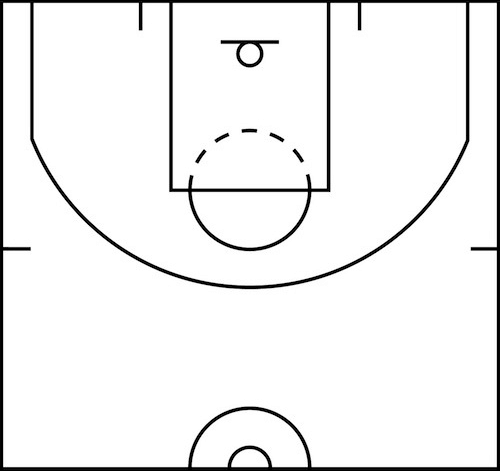

In [2]:
filename = "../data/nba_court.png"
img = None  
try: 
    img = Image.open(filename)
except IOError:
    pass

width, height = img.size
img = img.crop((0, 0.55, width - 0.7, height))
img

In [4]:
img_arr = np.array(img)
img_arr.shape

(471, 500, 3)

In [6]:
img_flat = np.mean(img_arr, axis=2)
img_flat.shape

(471, 500)

In [7]:
# np.savetxt("nba_court.csv", img_flat, delimiter=",")

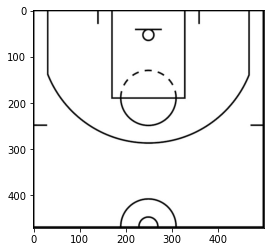

In [8]:
plt.imshow(img_flat, cmap="gray")

In [10]:
df = pd.read_csv("../data/nba_court.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17.0,24.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,20.0,24.0
2,0.0,0.0,0.0,45.0,61.0,57.0,52.0,56.0,55.0,55.0,...,52.0,55.0,55.0,55.0,57.0,61.0,45.0,0.0,0.0,0.0
3,5.0,0.0,0.0,199.0,243.0,239.0,236.0,245.0,241.0,241.0,...,241.0,241.0,241.0,241.0,243.0,245.0,194.0,0.0,0.0,5.0
4,0.0,0.0,0.0,220.0,255.0,253.0,250.0,253.0,255.0,255.0,...,255.0,255.0,255.0,253.0,253.0,255.0,224.0,0.0,0.0,5.0


In [11]:
np.array(df).shape

(471, 500)

## Preprocessing raw shot data 

In [15]:
def parse_time(time_left, quarter, overtime):
    time_split = time_left.split(":")
    minutes = int(time_split[0])
    sec = float(time_split[1])
    total = minutes * 60 + sec
    if overtime:
        return total
    quarter_length = 12 * 60
    total += (quarter_length * (4 - quarter))
    return total
        

def preprocess(df):
    df["x"] = df["x"].str.rstrip("px").astype("int64")
    df["y"] = df["y"].str.rstrip("px").astype("int64")
    df = df.rename({"x": "y", "y":"x"}, axis=1)
    df["shots_by"] = df["play"].apply(lambda x: " ".join(str(x).split("<br>")[1].split()[:-5]))
    df["outcome"] = df["play"].apply(lambda x: str(x).split("<br>")[1].split()[-5]) 
    df["attempt"] = df["play"].apply(lambda x: str(x).split("<br>")[1].split()[-4])
    df["overtime"] = df["play"].apply(lambda x: str(x).split()[1].startswith("overtime")).astype("int32")
    df["team"] = df.apply(
        lambda x: 
        " ".join(str(x["play"]).split("<br>")[2].split()[:-3]) 
        if x["outcome"]=="made" 
        else 
        " ".join(str(x["play"]).split("<br>")[2].split()[:-2]), axis=1)
    df["winner_score"] = df.apply(
        lambda x: 
        int(str(x["play"]).split("<br>")[2].split()[-1].split("-")[0]) 
        if x["winner"]==x["team"] 
        else 
        int(str(x["play"]).split("<br>")[2].split()[-1].split("-")[1]), axis=1)
    df["loser_score"] = df.apply(
        lambda x: 
        int(str(x["play"]).split("<br>")[2].split()[-1].split("-")[1]) 
        if x["winner"]==x["team"] 
        else 
        int(str(x["play"]).split("<br>")[2].split()[-1].split("-")[0]), axis=1)
    df["team_score"] = df.apply(
        lambda x: 
        int(str(x["play"]).split("<br>")[2].split()[-1].split("-")[0]) 
        if x["outcome"]=="missed" 
        else 
        int(str(x["play"]).split("<br>")[2].split()[-1].split("-")[0]) - int(str(x["attempt"])[0]), axis=1)
    df["opp_score"] = df["play"].apply(lambda x: int(str(x).split("<br>")[2].split()[-1].split("-")[1]))
    df["distance"] = df["play"].apply(lambda x: int(x.split('<br>')[1].split()[-2]))
    df["time_remaining_game"] = df.apply(lambda x: parse_time(x["time_remaining"], x["quarter"], x["overtime"]), axis=1)

    
    hoop = (250, 50)
    x_offset = hoop[0] - df[df["distance"]==0]["x"].mean()
    y_offset = hoop[1] - df[df["distance"]==0]["y"].mean()
    df["x_adj"] = df["x"].apply(lambda x: x + x_offset)
    df["y_adj"] = df["y"].apply(lambda x: x + y_offset)
    return df

In [18]:
df2019 = pd.read_csv("../data/shots-2019.csv").drop("Unnamed: 0", axis=1)
df2019.head()

,game_id,year,month,day,winner,loser,x,y,play,time_remaining,quarter,shots_by,outcome,attempt,distance,team,winner_score,loser_score
0,201910220TOR,2019,10,22,Toronto,New Orleans,147px,242px,"1st quarter, 11:48.0 remaining<br>Lonzo Ball m...",11:48.0,1,Lonzo Ball,missed,2-pointer,11ft,New Orleans,0,0
1,201910220TOR,2019,10,22,Toronto,New Orleans,27px,240px,"1st quarter, 11:47.0 remaining<br>Derrick Favo...",11:47.0,1,Derrick Favors,made,2-pointer,1ft,New Orleans,0,2
2,201910220TOR,2019,10,22,Toronto,New Orleans,60px,256px,"1st quarter, 11:29.0 remaining<br>OG Anunoby m...",11:29.0,1,OG Anunoby,missed,2-pointer,3ft,Toronto,0,2
3,201910220TOR,2019,10,22,Toronto,New Orleans,32px,320px,"1st quarter, 11:16.0 remaining<br>Jrue Holiday...",11:16.0,1,Jrue Holiday,missed,2-pointer,8ft,New Orleans,0,2
4,201910220TOR,2019,10,22,Toronto,New Orleans,208px,418px,"1st quarter, 11:11.0 remaining<br>Kyle Lowry m...",11:11.0,1,Kyle Lowry,missed,3-pointer,25ft,Toronto,0,2


In [19]:
df2019_process = preprocess(df2019)
df2019_process.head()

,game_id,year,month,day,winner,loser,y,x,play,time_remaining,...,distance,team,winner_score,loser_score,overtime,team_score,opp_score,time_remaining_game,x_adj,y_adj
0,201910220TOR,2019,10,22,Toronto,New Orleans,147,242,"1st quarter, 11:48.0 remaining<br>Lonzo Ball m...",11:48.0,...,11,New Orleans,0,0,0,0,0,2868.0,251.929847,163.416223
1,201910220TOR,2019,10,22,Toronto,New Orleans,27,240,"1st quarter, 11:47.0 remaining<br>Derrick Favo...",11:47.0,...,1,New Orleans,0,2,0,0,0,2867.0,249.929847,43.416223
2,201910220TOR,2019,10,22,Toronto,New Orleans,60,256,"1st quarter, 11:29.0 remaining<br>OG Anunoby m...",11:29.0,...,3,Toronto,0,2,0,0,2,2849.0,265.929847,76.416223
3,201910220TOR,2019,10,22,Toronto,New Orleans,32,320,"1st quarter, 11:16.0 remaining<br>Jrue Holiday...",11:16.0,...,8,New Orleans,0,2,0,2,0,2836.0,329.929847,48.416223
4,201910220TOR,2019,10,22,Toronto,New Orleans,208,418,"1st quarter, 11:11.0 remaining<br>Kyle Lowry m...",11:11.0,...,25,Toronto,0,2,0,0,2,2831.0,427.929847,224.416223


In [20]:
# df2019_process.to_csv("shots-2019-preprocessed.csv")

In [21]:
df2000 = pd.read_csv("../data/shots-2000.csv").drop("Unnamed: 0", axis=1)
df2000.head()

,game_id,year,month,day,winner,loser,x,y,play,time_remaining,quarter,shots_by,outcome,attempt,distance,team,winner_score,loser_score
0,200011040VAN,2000,11,4,LA Lakers,Vancouver,126px,108px,"1st quarter, 11:44.0 remaining<br>Michael Dick...",11:44.0,1,Michael Dickerson,missed,2-pointer,15ft,Vancouver,0,0
1,200011040VAN,2000,11,4,LA Lakers,Vancouver,126px,403px,"1st quarter, 11:26.0 remaining<br>Kobe Bryant ...",11:26.0,1,Kobe Bryant,missed,2-pointer,18ft,LA Lakers,0,0
2,200011040VAN,2000,11,4,LA Lakers,Vancouver,200px,87px,"1st quarter, 11:20.0 remaining<br>Mike Bibby m...",11:20.0,1,Mike Bibby,missed,2-pointer,21ft,Vancouver,0,0
3,200011040VAN,2000,11,4,LA Lakers,Vancouver,244px,310px,"1st quarter, 10:58.0 remaining<br>Kobe Bryant ...",10:58.0,1,Kobe Bryant,missed,2-pointer,21ft,LA Lakers,0,0
4,200011040VAN,2000,11,4,LA Lakers,Vancouver,50px,222px,"1st quarter, 10:49.0 remaining<br>Othella Harr...",10:49.0,1,Othella Harrington,made,2-pointer,2ft,Vancouver,0,2


In [22]:
df2000_process = preprocess(df2000)
df2000_process.head()

,game_id,year,month,day,winner,loser,y,x,play,time_remaining,...,distance,team,winner_score,loser_score,overtime,team_score,opp_score,time_remaining_game,x_adj,y_adj
0,200011040VAN,2000,11,4,LA Lakers,Vancouver,126,108,"1st quarter, 11:44.0 remaining<br>Michael Dick...",11:44.0,...,15,Vancouver,0,0,0,0,0,2864.0,118.004873,125.975867
1,200011040VAN,2000,11,4,LA Lakers,Vancouver,126,403,"1st quarter, 11:26.0 remaining<br>Kobe Bryant ...",11:26.0,...,18,LA Lakers,0,0,0,0,0,2846.0,413.004873,125.975867
2,200011040VAN,2000,11,4,LA Lakers,Vancouver,200,87,"1st quarter, 11:20.0 remaining<br>Mike Bibby m...",11:20.0,...,21,Vancouver,0,0,0,0,0,2840.0,97.004873,199.975867
3,200011040VAN,2000,11,4,LA Lakers,Vancouver,244,310,"1st quarter, 10:58.0 remaining<br>Kobe Bryant ...",10:58.0,...,21,LA Lakers,0,0,0,0,0,2818.0,320.004873,243.975867
4,200011040VAN,2000,11,4,LA Lakers,Vancouver,50,222,"1st quarter, 10:49.0 remaining<br>Othella Harr...",10:49.0,...,2,Vancouver,0,2,0,0,0,2809.0,232.004873,49.975867


In [23]:
# df2000_process.to_csv("shots-2000-preprocessed.csv")